In [21]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install tensorflow-gpu

     |████████████████████████████████| 454.3 MB 13 kB/s  eta 0:00:011    |████▊                           | 67.0 MB 23.0 MB/s eta 0:00:17     |████▊                           | 67.7 MB 23.0 MB/s eta 0:00:17     |█████                           | 71.0 MB 23.0 MB/s eta 0:00:17     |█████                           | 71.9 MB 23.0 MB/s eta 0:00:17     |█████▏                          | 73.9 MB 23.0 MB/s eta 0:00:17     |█████▍                          | 75.9 MB 23.0 MB/s eta 0:00:17     |█████▌                          | 78.1 MB 23.0 MB/s eta 0:00:17     |█████▋                          | 80.2 MB 22.5 MB/s eta 0:00:17     |█████▊                          | 81.2 MB 22.5 MB/s eta 0:00:17     |███████▋                        | 107.9 MB 16.1 MB/s eta 0:00:22     |███████▊                        | 110.2 MB 16.1 MB/s eta 0:00:22��▍               | 233.1 MB 23.8 MB/s eta 0:00:10    | 234.6 MB 23.8 MB/s eta 0:00:10     |██████████████████████          | 311.1 MB 20.2 MB/s eta 0:00:08     |████████

In [24]:
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten,Dense,Lambda,Input,Dropout
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [25]:
IMAGE_SIZE = [224,224]

In [26]:
train_path = '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train'
test_path = '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/test'
valid_path = '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/valid'

In [27]:
folders = glob('/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/*')

In [28]:
folders

['/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Cocker',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/American Spaniel',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Bichon Frise',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Beagle',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Pomeranian',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Bermaise',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Schnauzer',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Groenendael',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Komondor',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Afghan',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Bluetick',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Pekinese',
 '/kaggle/input/70-dog-breedsimage-data-set/dog_classes/train/Chow',
 '/kaggle/input/70-dog-breedsimage-data-set

In [29]:
incept = InceptionResNetV2(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [30]:
for layer in incept.layers:
  layer.trainable = False

In [31]:
x=Flatten()(incept.output)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)
predict = Dense(len(folders),activation = 'softmax')(x)

In [32]:
model = Model(inputs=incept.input,outputs=predict)

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

In [34]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [35]:
callback = tf.keras.callbacks.EarlyStopping(
      monitor="val_accuracy",
          min_delta=0,
              patience=3,
                verbose=1,
                      mode="max",
                          baseline=None,
                              restore_best_weights=False,
                              )

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = 'dog_inceptionresnet-{epoch:08d}.hdf5'
checkpoint = ModelCheckpoint(filepath,verbose=1,monitor='val_accuracy',save_best_only=True,mode ='max')
callbacks_list =[checkpoint,callback]

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                      horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
training_set = train_datagen.flow_from_directory(train_path,class_mode='categorical',batch_size=32,target_size=(224,224))

Found 7946 images belonging to 70 classes.


In [39]:
valid_set = valid_datagen.flow_from_directory(valid_path,class_mode='categorical',batch_size=32,target_size=(224,224))

Found 700 images belonging to 70 classes.


In [40]:
test_set = test_datagen.flow_from_directory(test_path,class_mode='categorical',batch_size=32,target_size=(224,224))

Found 700 images belonging to 70 classes.


In [41]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [42]:
ir = model.fit_generator(training_set,
                         validation_data=valid_set,epochs=10,steps_per_epoch=len(training_set),validation_steps=len(valid_set),callbacks=callbacks_list,verbose=1)

Epoch 1/10
249/249 [==============================] - ETA: 0s - loss: 4.7662 - accuracy: 0.6087WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f90870d75f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
249/249 [==============================] - 187s 701ms/step - loss: 4.7547 - accuracy: 0.6093 - val_loss: 0.6712 - val_accuracy: 0.8929

Epoch 00001: val_accuracy improved from -inf to 0.89286, saving model to dog_inceptionresnet-00000001.hdf5
Epoch 2/10
249/249 [==============================] - 154s 619ms/step - loss: 0.5915 - accuracy: 0.8589 - val_loss: 0.8213 - val_accuracy: 0.9043

Epoch 00002: val_accuracy improve

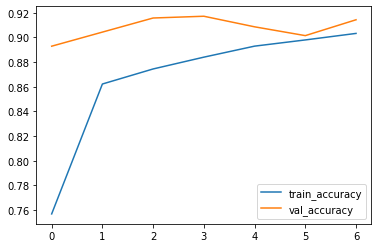

In [43]:
plt.plot(ir.history['accuracy'],label='train_accuracy')
plt.plot(ir.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

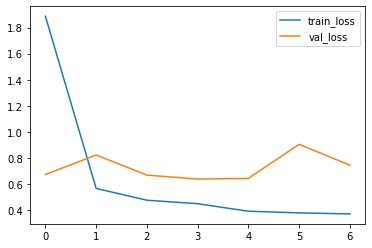

In [44]:
plt.plot(ir.history['loss'],label='train_loss')
plt.plot(ir.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [45]:
from tensorflow.keras.models import load_model
model.save('dogbreed_inceptresnet_final.h5')

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
np.argmax(y_pred,axis=1)

In [ ]:
#img = image.load_img('/content/drive/MyDrive/IMG_3474.PNG',target_size=(224,224))
#imgg = image.img_to_array(img)
#imgg.shape
#imgg = imgg/255

In [ ]:
#from tensorflow.keras.applications.inception_v3 import preprocess_input
#imgg = np.expand_dims(imgg,axis=0)
#img_data = preprocess_input(imgg)
#img_data.shape

In [ ]:
#predict = model.predict(imgg)

In [ ]:
#np.argmax(predict,axis=1)